In [1]:
import detectron2, cv2, random
import os, json, itertools
import numpy as np
import torch, torchvision
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from matplotlib import pyplot as plt

In [2]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo

In [3]:
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    image_id = 0
    for _, v in imgs_anns.items():
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width
        
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        image_id += 1
    return dataset_dicts

In [4]:
for d in ["train", "val"]:
    DatasetCatalog.register("balloon/" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon/" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon/train")

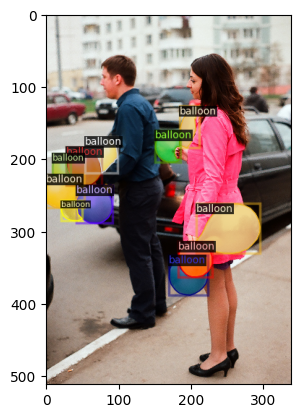

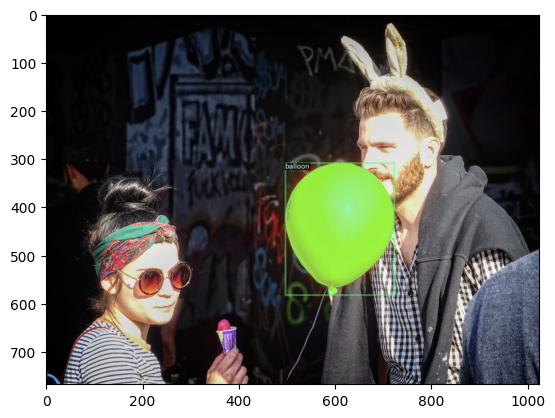

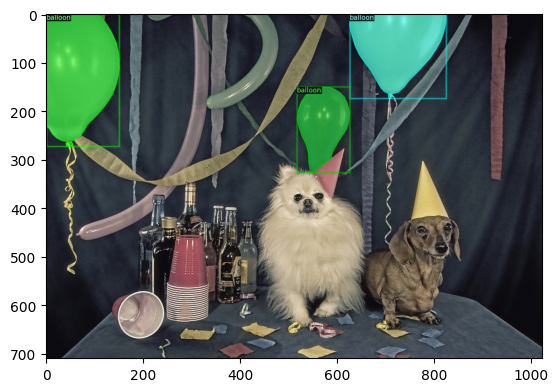

In [5]:
# Visualize Dataset
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())
    plt.show()

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon/train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/17 19:54:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/17 19:54:26 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[01/17 19:54:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 255          |
|            |              |
[01/17 19:54:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/17 19:54:26 d2.data.build]: Using training sampler TrainingSampler
[01/17 19:54:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/17 19:54:26 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[01/17 19:54:26 d2.data.common]: Serialized dataset takes 0.17 MiB
[01/17 19:54:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/CO

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/17 19:54:26 d2.engine.train_loop]: Starting training from iteration 0


/home/yaroslav/anaconda3/envs/my-ml-env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/17 19:54:31 d2.utils.events]:  eta: 0:01:00  iter: 19  total_loss: 2.06  loss_cls: 0.7176  loss_box_reg: 0.5821  loss_mask: 0.6846  loss_rpn_cls: 0.02472  loss_rpn_loc: 0.005257  time: 0.2164  data_time: 0.0116  lr: 1.6068e-05  max_mem: 2544M
[01/17 19:54:35 d2.utils.events]:  eta: 0:00:56  iter: 39  total_loss: 1.948  loss_cls: 0.6056  loss_box_reg: 0.6555  loss_mask: 0.5951  loss_rpn_cls: 0.04511  loss_rpn_loc: 0.01116  time: 0.2155  data_time: 0.0029  lr: 3.2718e-05  max_mem: 2544M
[01/17 19:54:40 d2.utils.events]:  eta: 0:00:51  iter: 59  total_loss: 1.631  loss_cls: 0.4566  loss_box_reg: 0.6119  loss_mask: 0.4795  loss_rpn_cls: 0.02559  loss_rpn_loc: 0.007251  time: 0.2148  data_time: 0.0030  lr: 4.9367e-05  max_mem: 2544M
[01/17 19:54:44 d2.utils.events]:  eta: 0:00:46  iter: 79  total_loss: 1.501  loss_cls: 0.3814  loss_box_reg: 0.6013  loss_mask: 0.3679  loss_rpn_cls: 0.02733  loss_rpn_loc: 0.01123  time: 0.2123  data_time: 0.0029  lr: 6.6017e-05  max_mem: 2544M
[01/17 19:5

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[01/17 19:55:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


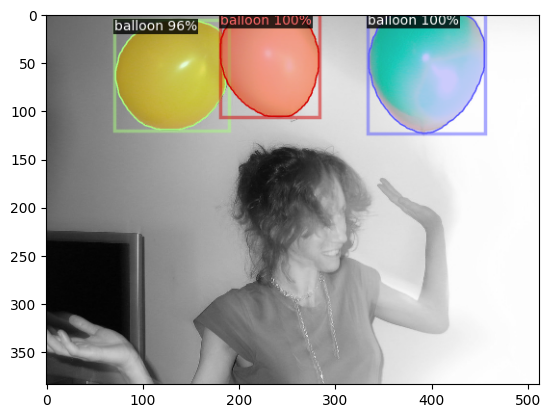

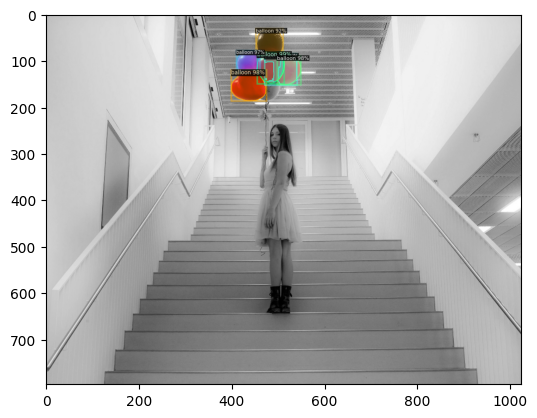

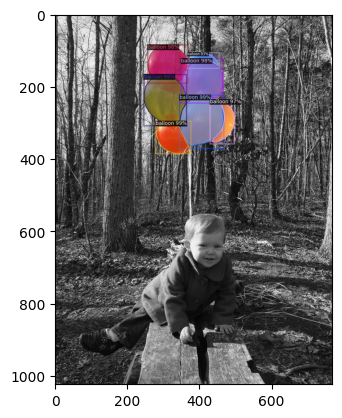

In [16]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()

In [9]:
test_dataset_dicts = get_balloon_dicts("balloon/val")
test_dataset_metadata = MetadataCatalog.get("balloon/val")

In [14]:
evaluator = COCOEvaluator("balloon/val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon/val")

WARNING [01/17 19:56:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/17 19:56:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/17 19:56:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/17 19:56:34 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[01/17 19:56:34 d2.data.common]: Serialized dataset takes 0.04 MiB


In [11]:
%%time
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/17 19:55:35 d2.evaluation.evaluator]: Start inference on 13 batches
[01/17 19:55:36 d2.evaluation.evaluator]: Inference done 11/13. Dataloading: 0.0009 s/iter. Inference: 0.0521 s/iter. Eval: 0.0037 s/iter. Total: 0.0567 s/iter. ETA=0:00:00
[01/17 19:55:36 d2.evaluation.evaluator]: Total inference time: 0:00:00.472566 (0.059071 s / iter per device, on 1 devices)
[01/17 19:55:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.051927 s / iter per device, on 1 devices)
[01/17 19:55:36 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/17 19:55:36 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/17 19:55:36 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/17 19:55:36 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/17 19:55:36 d2.evaluation.fast_eval_api]: COCOeval

OrderedDict([('bbox',
              {'AP': 73.21915198607549,
               'AP50': 83.59947041215749,
               'AP75': 80.82719318443472,
               'APs': 0.0,
               'APm': 52.45776006172046,
               'APl': 91.10599023560968}),
             ('segm',
              {'AP': 75.90940407237508,
               'AP50': 80.78304258997329,
               'AP75': 80.78304258997329,
               'APs': 0.0,
               'APm': 51.94779477947794,
               'APl': 96.68957427842263})])